# Import Libraries

In [1]:
from cm_api import *
from cm_config import config
import datetime
from helper_funct import *
from helper_funct1 import *
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from utility import *
import datetime


In [2]:
rt = config['refresh_token']
api_token = get_api_token(rt)


In [14]:
api_reset_time(api_token)

'2021-02-01 00:46:48'

In [23]:
date_list = get_date_range('2020-06-01', '2021-01-26', 'W')
date_list[0]

'2020-06-07'

# Collect Data from Tiktok's Top 100 Weekly Charts

In [31]:
#collect top tracks since June 1st, 2020
data = get_tiktok_chart_data(api_token, 'tracks', '2021-01-21', 'weekly', limit=100)
#parse data into dataframe (columns='title', 'artist', 'isrc', 'velocity', 'cm_id')
parsed_data = parse_tiktok_data(data)



# Clean Data

In [33]:
#drop duplicate tracks except for first occurrence
parsed_data.drop_duplicates(subset='title', keep='first', inplace=True)

In [34]:
#remove timestap from add date
parsed_data['added_at'] = pd.to_datetime(parsed_data['added_at']).dt.date

In [35]:
#remove timestamp from release date
parsed_data['release_dates'] = [x[0] for x in parsed_data['release_dates']]
parsed_data['release_dates'] = pd.to_datetime(parsed_data['release_dates']).dt.date

# Feature Engineering

## One-Week Before Initial Add Date
Need this date to find social media data for artists a week prior they were added to chart add date

In [31]:
import datetime
top_tktracks['added_at'] = pd.to_datetime(top_tktracks['added_at'])

In [32]:

before_date_bucket = []
for row in top_tktracks.iterrows():
    before_date = row[1]['added_at'] - datetime.timedelta(days=21)
    before_date_bucket.append(before_date)
top_tktracks['before_tiktok_date'] =  before_date_bucket

In [35]:
#save dataset
# parsed_data.to_csv('data/tiktok_artists.csv', index_label='index')
#read in dataset
# top_tktracks = pd.read_csv('data/tiktok_artists.csv', index_col=0)
top_tktracks.head()

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,cm_artist_id,slisteners_before,slisteners_after,IG_f14,IG_f21,TW_f14,TW_f21,Tiktok_f14,Tiktok_f21
index,,,,,,,,,,,,,,,,,,,
0,1,2021-01-21,Shower,Becky G,USRC11400866,3.142857,15676244.0,69,2014-10-17,2020-12-31,4236,20348649.0,19992699.0,25526514.0,25528130.0,3114462.0,3121029.0,6100000.0,6100000.0
1,2,2021-01-21,Buss It,Erica Banks,USUYG1312999,0.285714,29555553.0,33,2020-05-15,2020-12-31,1443482,1256798.0,2128992.0,195472.0,241416.0,25491.0,26522.0,22600.0,55300.0
2,3,2021-01-21,Aesthetic,Xilo,QZFZ22071847,0.000000,28796568.0,224,2020-02-14,2020-12-31,3377623,66938.0,80330.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2021-01-21,Drugs (feat. Two Feet),UPSAHL,USQX91803133,19.142857,22290224.0,60,2019-01-18,2020-12-31,521020,3223708.0,3388571.0,91521.0,92955.0,7418.0,7609.0,484300.0,510400.0
4,5,2021-01-21,Oh No,Kreepa,USUYG1287925,0.285714,29425832.0,88,2019-12-13,2020-12-31,437999,1452759.0,1482020.0,NaN,NaN,NaN,NaN,NaN,NaN


## Chartmetric Artist ID - RESUME

In [5]:
#get artist id for each artist
id_bucket = []
for track_id in top_tktracks['cm_id']:
    artist_id = get_track_metadata(api_token, track_id)['artists'][0]['id']
    id_bucket.append(artist_id)
    
# #create artist ID feature to dataframe
top_tktracks['cm_artist_id'] = id_bucket

In [10]:
#reset index
top_tktracks.reset_index(drop='index', inplace=True)

## Spotify Listeners by Artist

In [5]:
#collect instagram followers for january 15th and january 21
bucket = []
for row in top_tktracks.iterrows():
    before = row[1]['before_tiktok_date']
    after = row[1]['added_at']

    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'spotify', before, after, field='listeners')['listeners']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        bucket.append(tup)
    else:
        tup = (None, None)
        bucket.append(tup)   
    
top_tktracks['slisteners_before'] = [x[0] for x in bucket]
top_tktracks['slisteners_after'] = [x[1] for x in bucket]

## Instagram Followers

In [36]:
#collect instagram followers for january 15th and january 21
bucket = []
for row in top_tktracks.iterrows():
    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'instagram', '2020-12-31', '2021-01-21', field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        bucket.append(tup)
    else:
        tup = (None, None)
        bucket.append(tup)   
    
top_tktracks['IG_f31'] = [x[0] for x in bucket]
top_tktracks['IG_f21'] = [x[1] for x in bucket]

## Twitter Followers

In [37]:
#collect Twitter
bucket = []
for row in top_tktracks.iterrows():
    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'twitter', '2020-12-31', '2021-01-21', field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        bucket.append(tup)
    else:
        tup = (None, None)
        bucket.append(tup)   
    
top_tktracks['TW_f31'] = [x[0] for x in bucket]
top_tktracks['TW_f21'] = [x[1] for x in bucket]

## Tiktok followers

In [91]:
#collect tiktok likes
bucket = []
for row in top_tktracks.iterrows():
    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'tiktok', '2020-12-31', '2021-01-21', field='likes')['likes']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        bucket.append(tup)
    else:
        tup = (None, None)
        bucket.append(tup)   
    
top_tktracks['Tiktok_l31'] = [x[0] for x in bucket]
top_tktracks['Tiktok_l21'] = [x[1] for x in bucket]

In [ ]:
#collect tiktok followers
bucket = []
for row in top_tktracks.iterrows():
    artist_id = row[1]['cm_artist_id']
    data = get_fan_metrics(api_token, artist_id,'tiktok', '2020-12-31', '2021-01-21', field='followers')['followers']
    if len(data) > 0:
        tup = (data[0]['value'], data[-1]['value'])
        bucket.append(tup)
    else:
        tup = (None, None)
        bucket.append(tup)   
    
top_tktracks['Tiktok_f31'] = [x[0] for x in bucket]
top_tktracks['Tiktok_f21'] = [x[1] for x in bucket]

In [94]:
#calculate Tiktok enegament (follow/likes)
top_tktracks['tiktok_engagement(31)'] = top_tktracks['Tiktok_f31']/top_tktracks['Tiktok_l31']
top_tktracks['tiktok_engagement(21)'] = top_tktracks['Tiktok_f21']/top_tktracks['Tiktok_l21']


In [3]:
#save dataset
# top_tktracks.to_csv('data/tiktok_artists.csv', index_label='index')
#read in dataset
top_tktracks = pd.read_csv('data/tiktok_artists.csv', index_col=0)


In [4]:
top_tktracks.head()

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,...,TW_f21,Tiktok_f14,Tiktok_f21,IG_f31,TW_f31,Tiktok_f31,Tiktok_l31,Tiktok_l21,tiktok_engagement(31),tiktok_engagement(21)
index,,,,,,,,,,,,,,,,,,,,,
0,1,2021-01-21,Shower,Becky G,USRC11400866,3.142857,15676244.0,69,2014-10-17,2020-12-31,...,3121029.0,6100000.0,6100000.0,25522353.0,3103665.0,6000000.0,29900000.0,30700000.0,0.200669,0.198697
1,2,2021-01-21,Buss It,Erica Banks,USUYG1312999,0.285714,29555553.0,33,2020-05-15,2020-12-31,...,26522.0,22600.0,55300.0,126223.0,21915.0,493.0,741.0,182600.0,0.665317,0.302848
2,3,2021-01-21,Aesthetic,Xilo,QZFZ22071847,0.000000,28796568.0,224,2020-02-14,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2021-01-21,Drugs (feat. Two Feet),UPSAHL,USQX91803133,19.142857,22290224.0,60,2019-01-18,2020-12-31,...,7609.0,484300.0,510400.0,85951.0,5998.0,375100.0,6500000.0,9100000.0,0.057708,0.056088
4,5,2021-01-21,Oh No,Kreepa,USUYG1287925,0.285714,29425832.0,88,2019-12-13,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

In [84]:
get_summary_statistics(top_tktracks['IG_f21'].dropna())

Min: 425
Mean: 5,338,401
Max: 127,943,242
25th percentile: 81,253
Median: 298,477
75th percentile: 2,711,238
Interquartile range (IQR): 2,629,985


## Instagram Followers

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


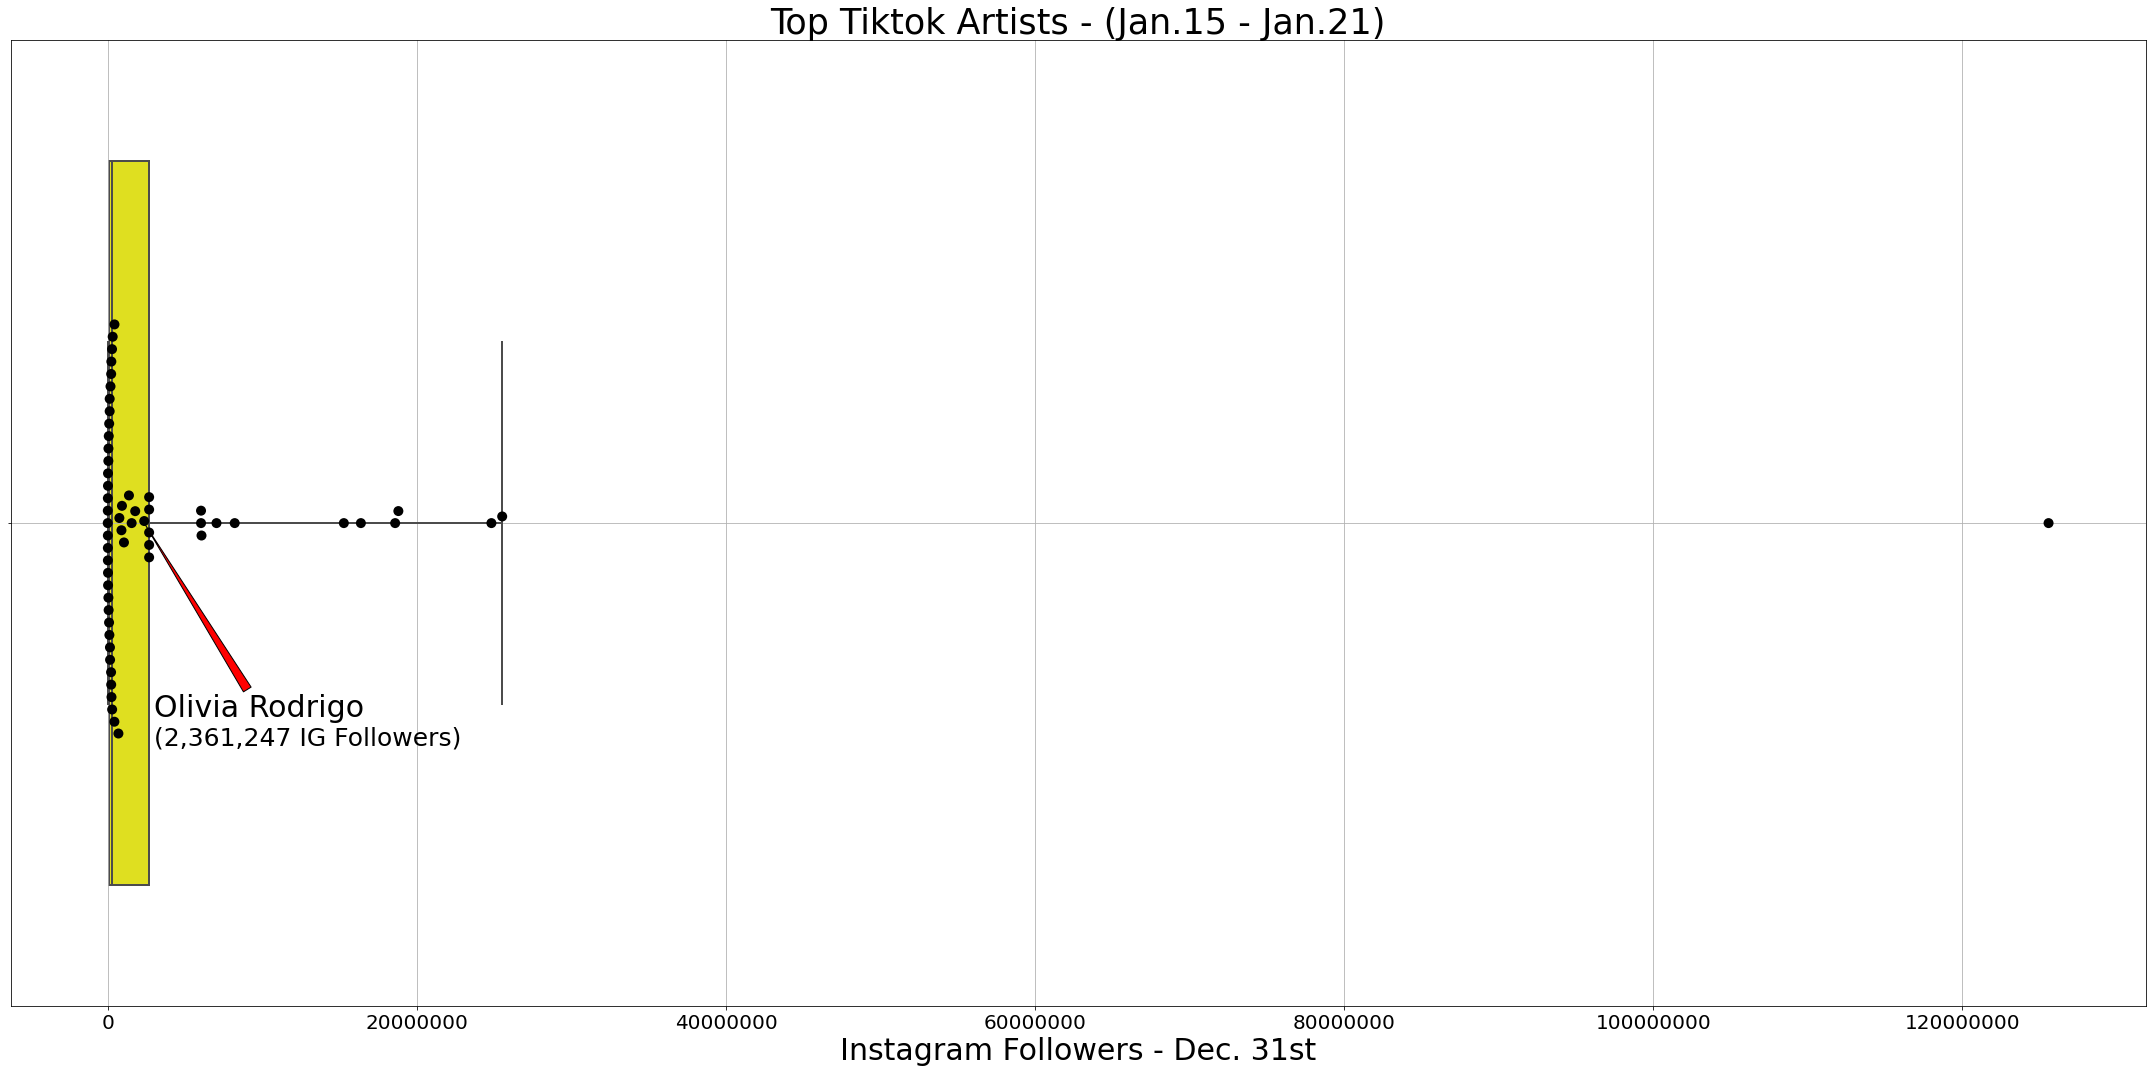

In [13]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['IG_f31'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['IG_f31'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.15 - Jan.21)', fontsize=35)
plt.xlabel('Instagram Followers - Dec. 31st', fontsize=30)
plt.ticklabel_format(style='plain', axis='x') #change xaxis from sci to plain style

#annotate outlier data point
plt.annotate('Olivia Rodrigo',xy=(2361247.0,0),xytext=(2961247.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=30)
plt.annotate('(2,361,247 IG Followers)',xy=(2361247.0,0),xytext=(2961247.0,.23),
                                                                                       fontsize=25)
# num=0
# ya=.1
# yb=.1
# for track in top_tktracks.iterrows():
#     if track[1]['IG_f31'] <= top_tktracks['IG_f31'].quantile(.75) and track[1]['IG_f21'] > top_tktracks['IG_f21'].quantile(.75):
#         if (num % 2) == 0:
#             plt.annotate(track[1]['artist'], xy=(track[1]['IG_f31'], 0),xytext=(track[1]['IG_f31'], ya),
#                      arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
#             num+=1
#             ya+=.1
#         else:
#             plt.annotate(track[1]['artist'], xy=(track[1]['IG_f31'], 0),xytext=(track[1]['IG_f31'], yb),
#                      arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
#             num+=1
#             yb+=.1
plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
# plt.savefig('visuals/ig_f31.jpeg')
plt.tight_layout()
plt.show()

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


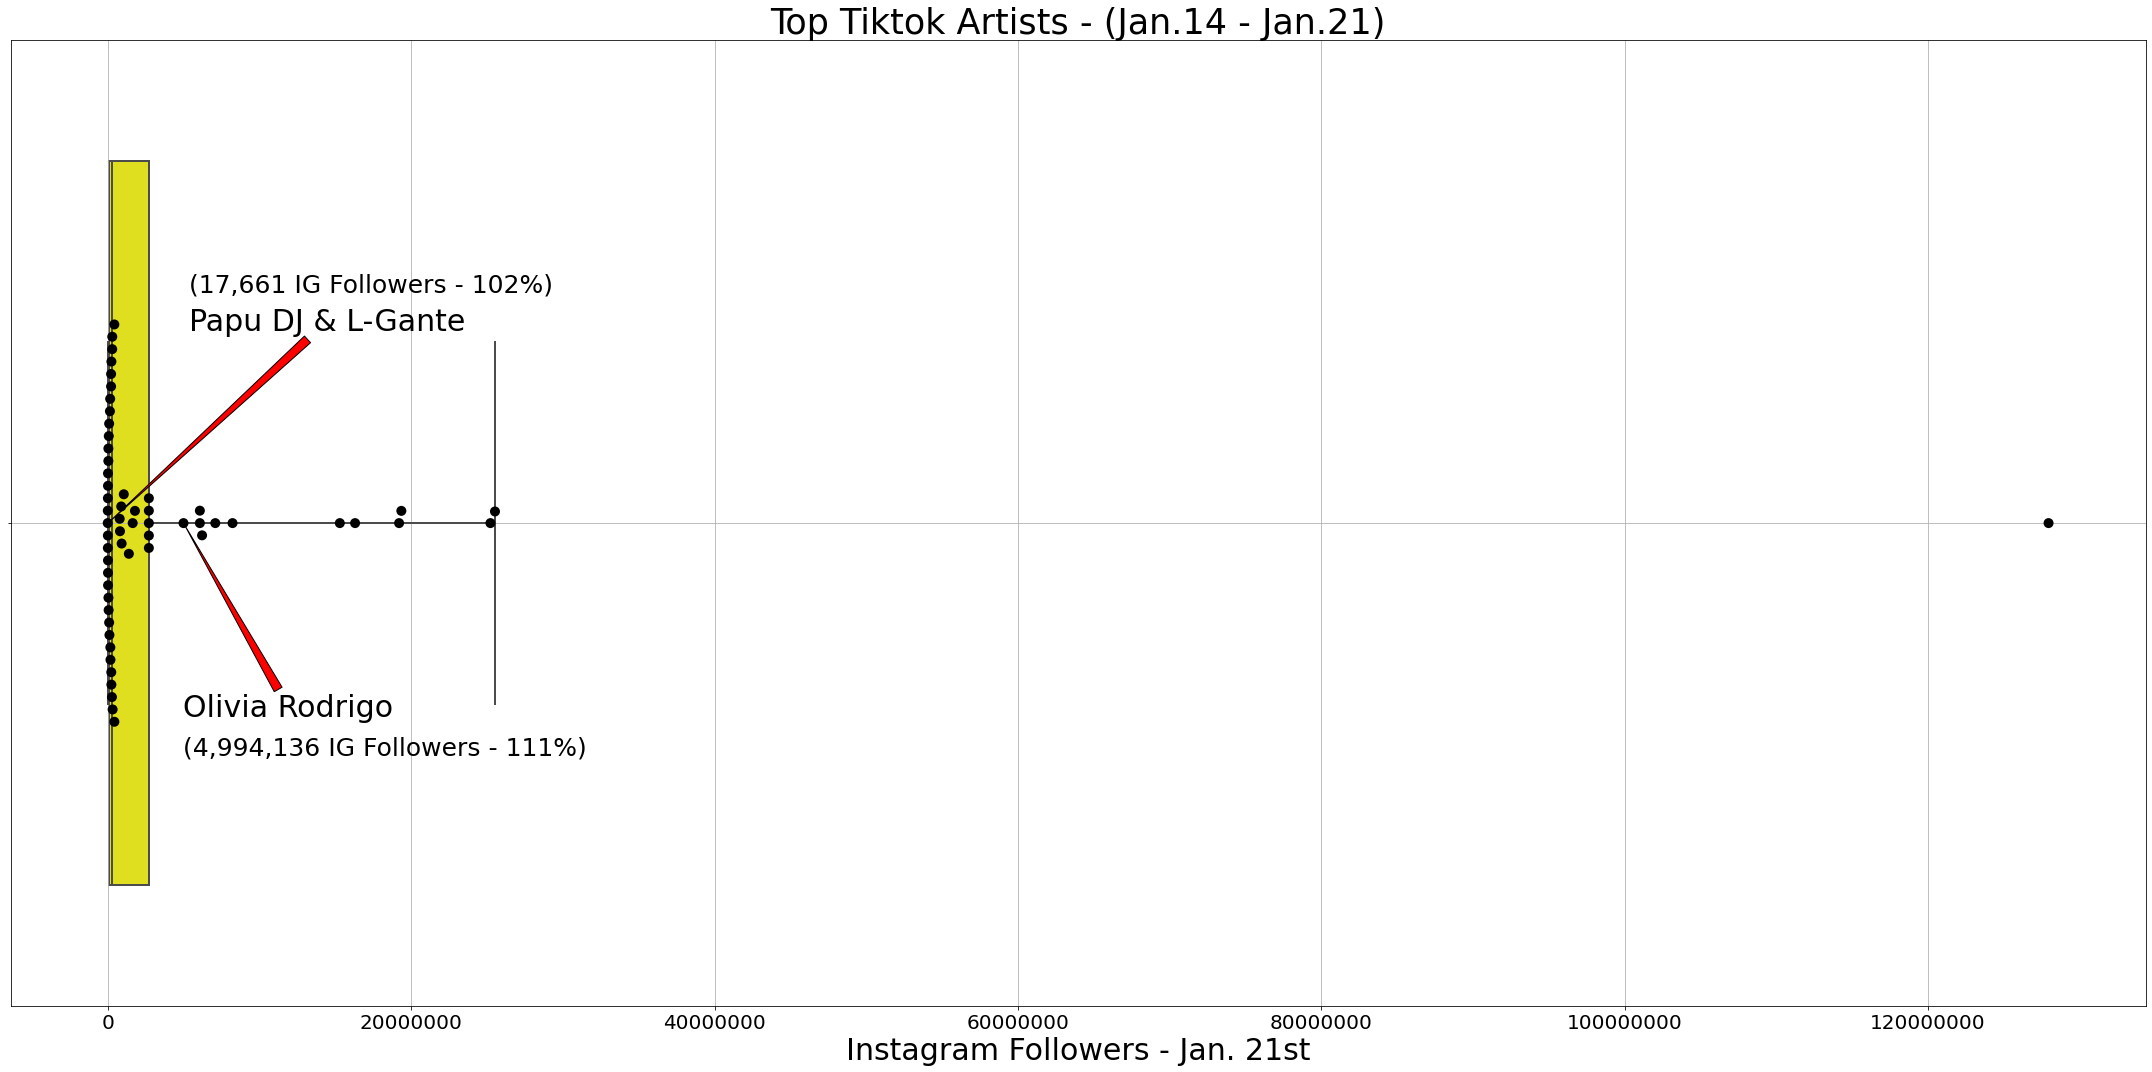

In [130]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['IG_f21'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['IG_f21'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=35)
plt.xlabel('Instagram Followers - Jan. 21st', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate outlier data point
plt.annotate('Olivia Rodrigo',xy=(4994136.0,0),xytext=(4994136.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=30)
plt.annotate('(4,994,136 IG Followers - 111%)',xy=(4994136.0,0),xytext=(4994136.0,.24),
                                                                                   fontsize=25)

#annotate second artist to double listeners

plt.annotate('Papu DJ & L-Gante',xy=(17661.0,0),xytext=(5337661.0,-.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=30)
plt.annotate('(17,661 IG Followers - 102%)',xy=(17661.0,0),xytext=(5337661.0,-.24),
                                                                                       fontsize=25)



plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
plt.savefig('visuals/ig_f21.jpeg')
plt.tight_layout()
plt.show()

In [134]:
# top_tktracks.sort_values('IG%', ascending=False)

## Twitter Followers

In [156]:
get_summary_statistics(top_tktracks['TW_f21'].dropna())

Min: 0
Mean: 1,515,665
Max: 25,536,399
25th percentile: 2,030
Median: 26,522
75th percentile: 1,042,067
Interquartile range (IQR): 1,040,037


/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


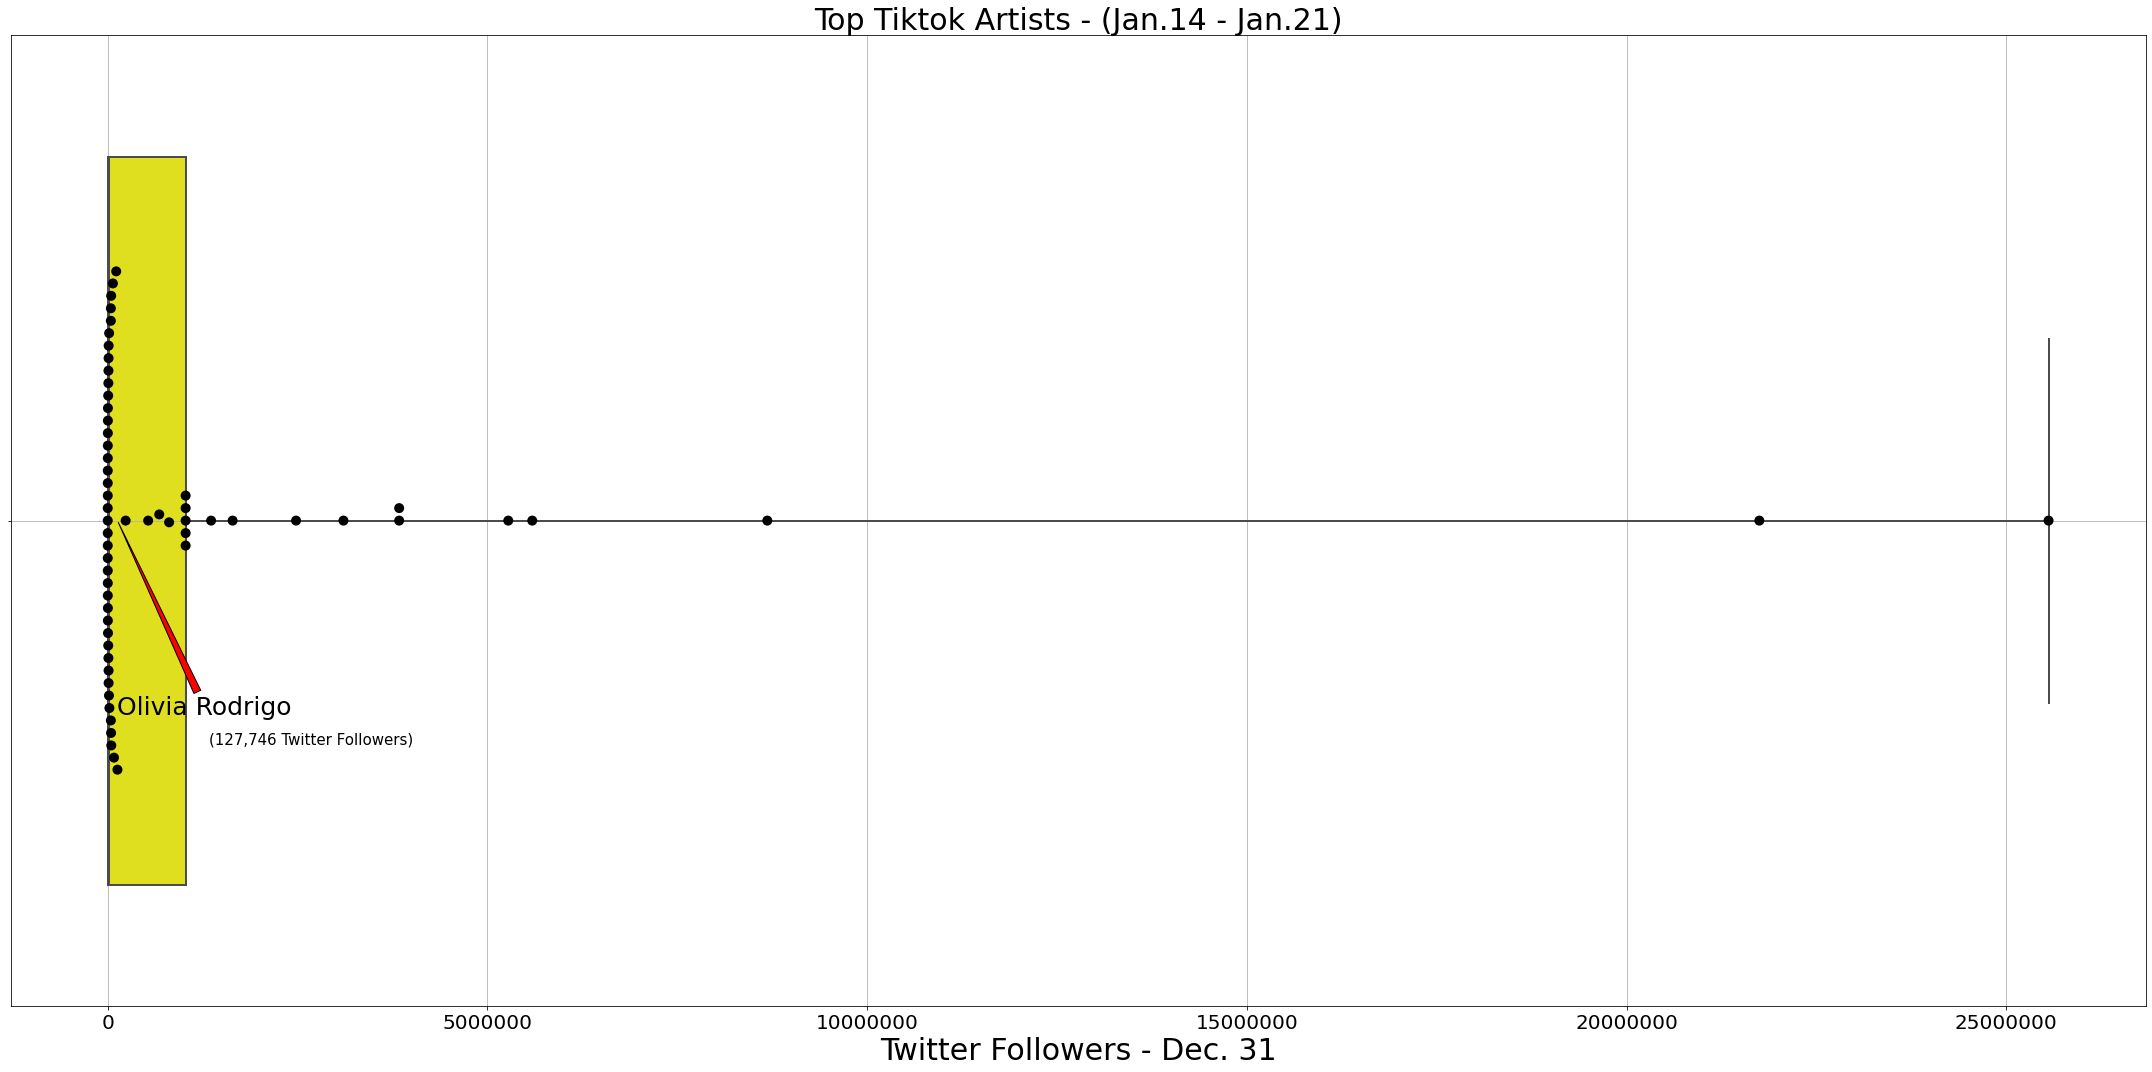

In [105]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['TW_f31'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['TW_f31'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=30)
plt.xlabel('Twitter Followers - Dec. 31', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate outlier data point
plt.annotate('Olivia Rodrigo',xy=(127746.0,0),xytext=(127746.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=25)
plt.annotate('(127,746 Twitter Followers)',xy=(127746.0,0),xytext=(1327846.0,.23),
                                                                                       fontsize=15)
# #annotate records who start below the third quartile on the 31st and end up above the third quartile after tiktok
# num=0
# ya=.1
# yb=.1
# for track in top_tktracks.iterrows():
#     if track[1]['TW_f31'] <= top_tktracks['TW_f31'].quantile(.75) and track[1]['TW_f21'] > top_tktracks['TW_f21'].quantile(.75):
#         if (num % 2) == 0:
#             plt.annotate(track[1]['artist'], xy=(track[1]['TW_f31'], 0),xytext=(track[1]['TW_f31'], ya),
#                      arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
#             num+=1
#             ya+=.1
#         else:
#             plt.annotate(track[1]['artist'], xy=(track[1]['TW_f31'], 0),xytext=(track[1]['TW_f31'], yb),
#                      arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
#             num+=1
#             yb+=.1
            
plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
plt.savefig('visuals/tw_f31.jpeg')
plt.tight_layout()
plt.show()

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


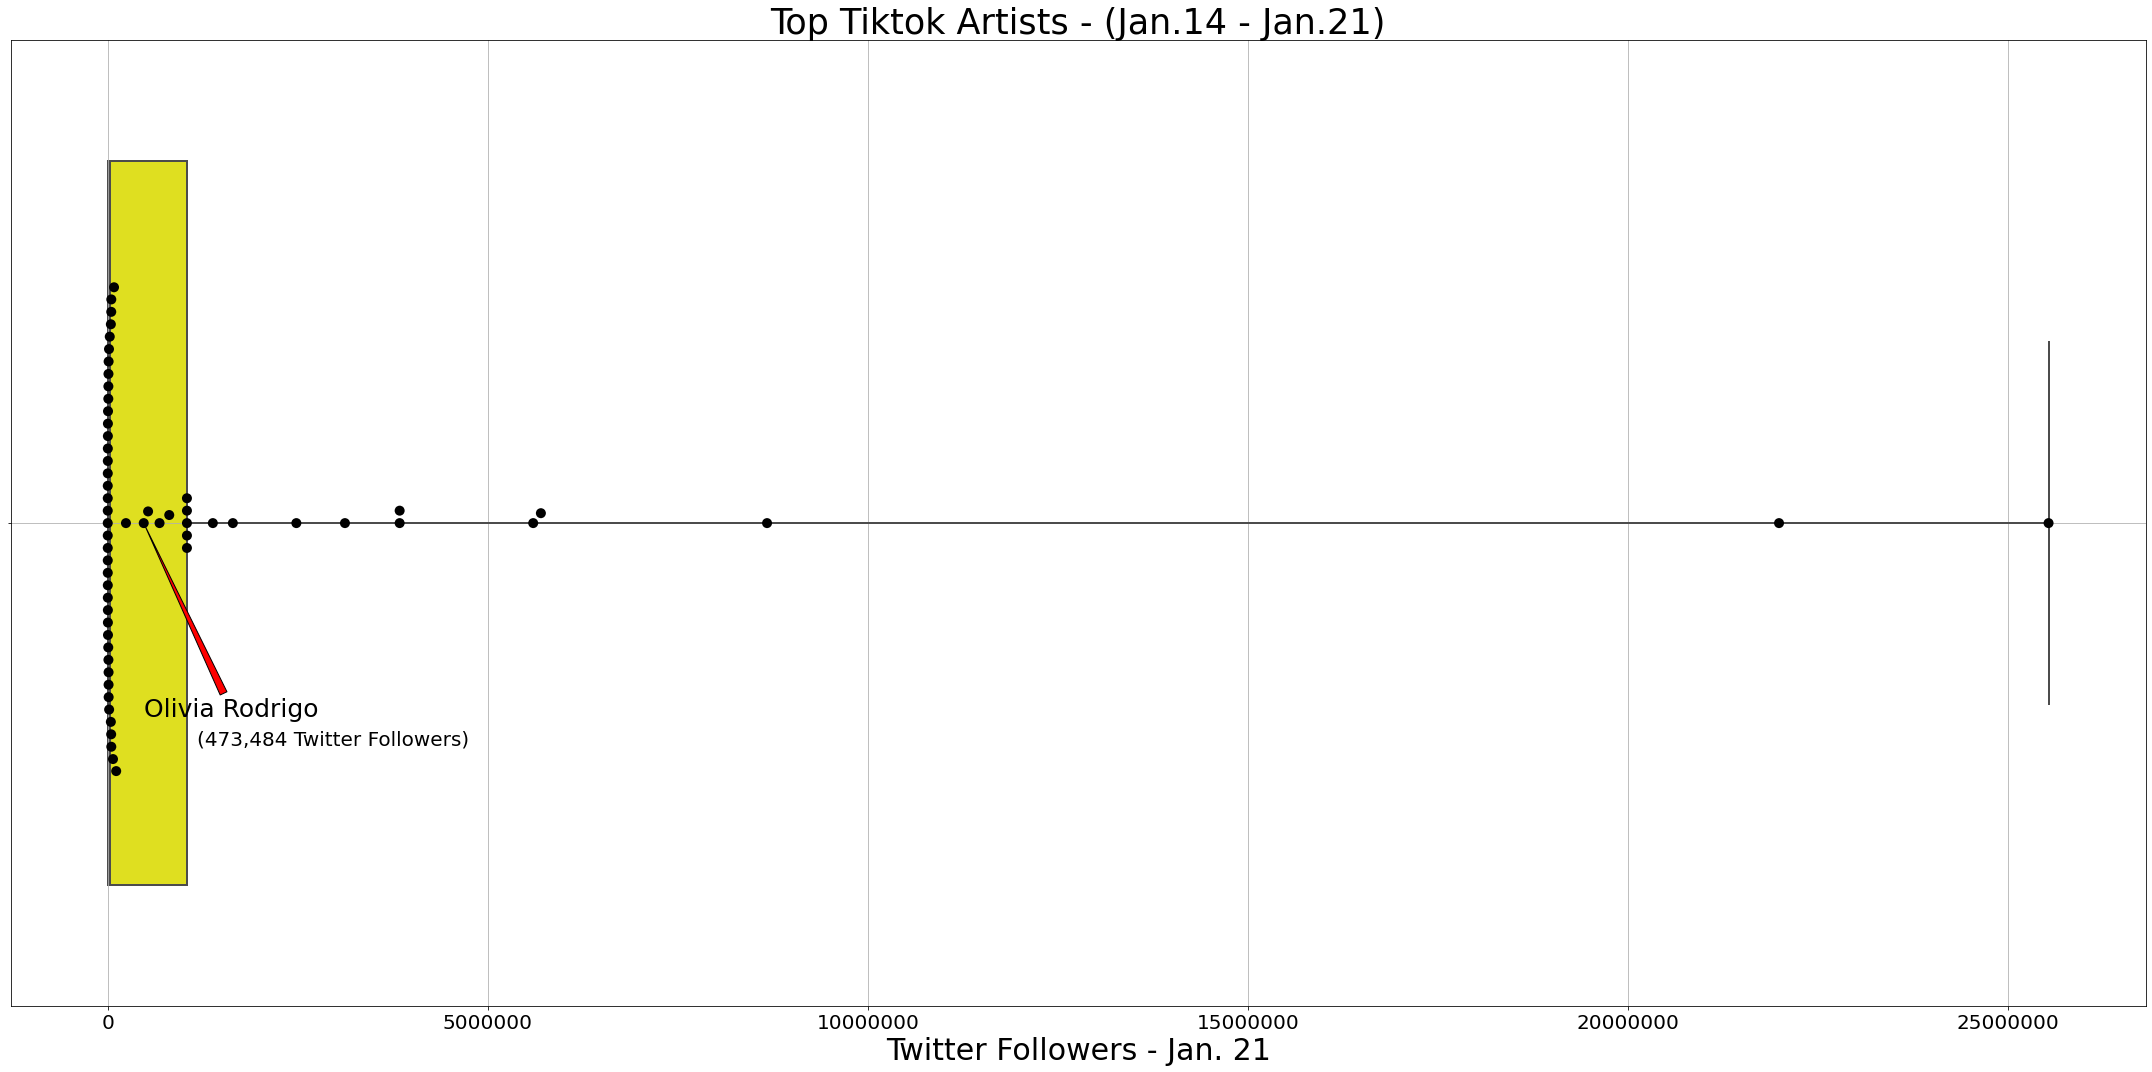

In [115]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['TW_f21'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['TW_f21'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=35)
plt.xlabel('Twitter Followers - Jan. 21', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate outlier data point
plt.annotate('Olivia Rodrigo',xy=(473484.0,0),xytext=(473484.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=25)
plt.annotate('(473,484 Twitter Followers)',xy=(473484.0,0),xytext=(1173484.0,.23),
                                                                                       fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
plt.savefig('visuals/tw_f21.jpeg')
plt.tight_layout()
plt.show()

In [76]:
get_summary_statistics(top_tktracks['TW_f21'].dropna())

Min: 0
Mean: 1,515,665
Max: 25,536,399
25th percentile: 2,030
Median: 26,522
75th percentile: 1,042,067
Interquartile range (IQR): 1,040,037


In [77]:
top_tktracks['TW%'] =  ((top_tktracks['TW_f21'] - top_tktracks['TW_f31'])/top_tktracks['TW_f31'])*100

In [98]:
top_tktracks['IG%'] =  ((top_tktracks['IG_f21'] - top_tktracks['IG_f31'])/top_tktracks['IG_f31'])*100

In [99]:
top_tktracks['TK%'] =  ((top_tktracks['Tiktok_f21'] - top_tktracks['Tiktok_f31'])/top_tktracks['Tiktok_f31'])*100

In [152]:


top_tktracks['sl%'] =  ((top_tktracks['slisteners_after'] - top_tktracks['slisteners_before'])/top_tktracks['slisteners_before'])*100

In [103]:
top_tktracks.sort_values('IG%', ascending=False)

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,...,IG_f31,TW_f31,Tiktok_f31,Tiktok_l31,Tiktok_l21,tiktok_engagement(31),tiktok_engagement(21),TW%,IG%,TK%
index,,,,,,,,,,,,,,,,,,,,,
39,40,2021-01-21,drivers license,Olivia Rodrigo,USUG12004749,NaN,32507149.0,12,2021-01-08,2020-12-31,...,2361247.0,127746.0,1400000.0,13000000.0,28500000.0,0.107692,0.143860,270.644873,111.504176,192.857143
35,36,2021-01-21,L-Gante Rkt,Papu DJ & L-Gante,USLZJ2043719,6.857143,31604648.0,39,2020-10-06,2020-12-31,...,8745.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.955403,NaN
1,2,2021-01-21,Buss It,Erica Banks,USUYG1312999,0.285714,29555553.0,33,2020-05-15,2020-12-31,...,126223.0,21915.0,493.0,741.0,182600.0,0.665317,0.302848,21.022131,91.261498,11117.038540
34,35,2021-01-21,Whoopty,Real CJ,USA2P2031043,-0.714286,31140457.0,88,2020-08-20,2020-12-31,...,216128.0,1093.0,NaN,NaN,NaN,NaN,NaN,11.344922,36.189665,NaN
16,17,2021-01-21,Paparazzi,Kim Dracula,QZNWY2036332,1.142857,32313666.0,40,2020-12-11,2020-12-31,...,124977.0,2517.0,2500000.0,36500000.0,41200000.0,0.068493,0.070388,27.532777,28.714884,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,2021-01-21,Cabaré,Nêgo Jhá©,QZMZ92059272,-1.428571,31488707.0,43,2020-09-07,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,93,2021-01-21,Mungkin Hari Ini Esok Atau Nanti,Anneth,FRX872024128,10.571429,31733715.0,54,2020-10-20,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,94,2021-01-21,Among Us,Sembari +,QZNWQ2008975,-0.428571,31876320.0,51,2020-11-01,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tiktok Followers

In [135]:
# top_tktracks.loc[top_tktracks['artist'] == 'Olivia Rodrigo']

In [155]:
get_summary_statistics(top_tktracks['Tiktok_f31'].dropna())

Min: 493
Mean: 2,582,710
Max: 33,300,000
25th percentile: 361,975
Median: 956,750
75th percentile: 1,475,000
Interquartile range (IQR): 1,113,025


/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


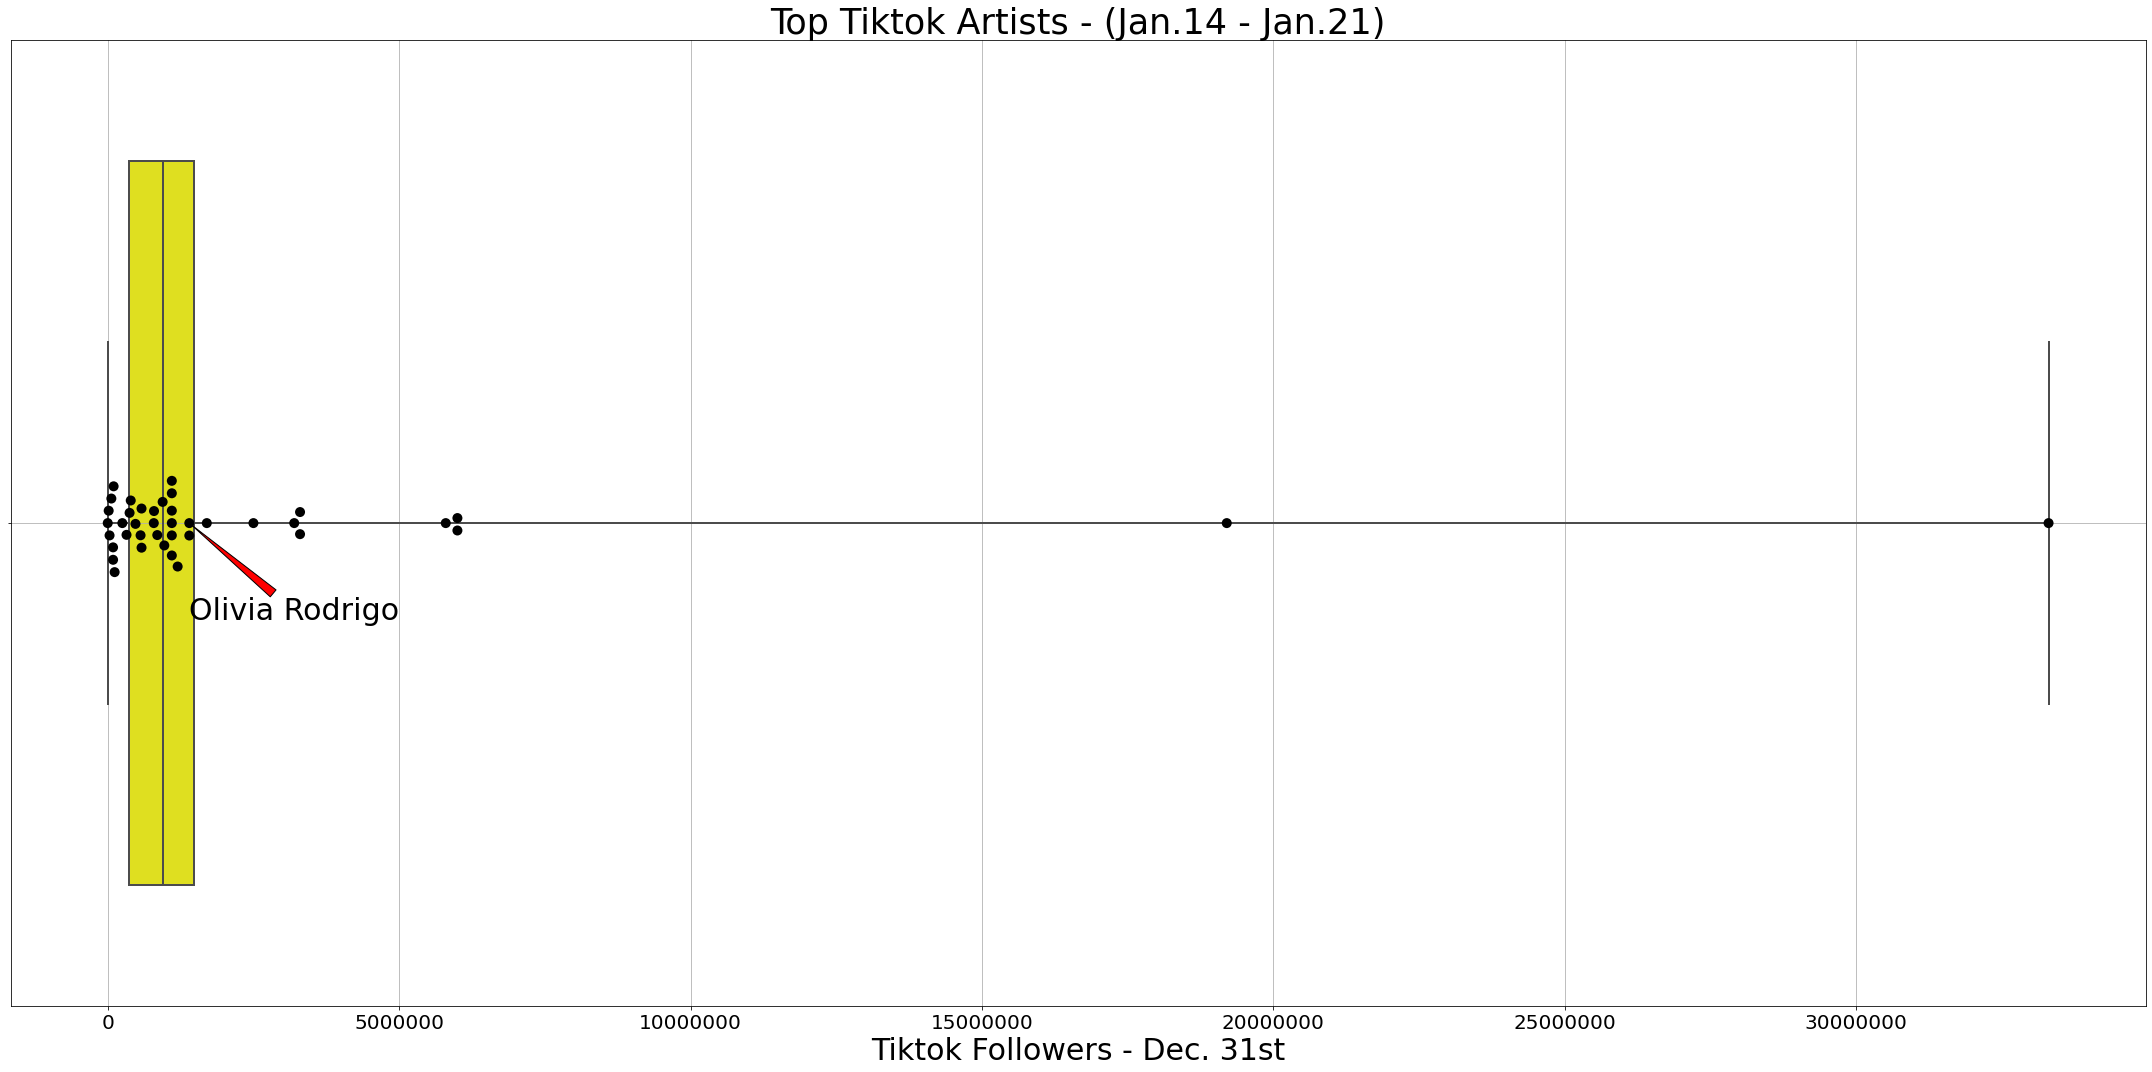

In [89]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['Tiktok_f31'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['Tiktok_f31'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=35)
plt.xlabel('Tiktok Followers - Dec. 31st', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate outlier data point
# plt.annotate('Olivia Rodrigo',xy=(1400000.0,0),xytext=(1700000.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
#                                                                                        fontsize=30)
# plt.annotate('(1,400,000 Tiktok Followers)',xy=(1400000.0,0),xytext=(2000000.0,.23),
#                                                                                        fontsize=20)

# annotate records who start below the third quartile on the 31st and end up above the third quartile after tiktok
num=0
ya=.1
yb=.1
for track in top_tktracks.iterrows():
    if track[1]['Tiktok_f31'] <= top_tktracks['Tiktok_f31'].quantile(.75) and track[1]['Tiktok_f21'] > top_tktracks['Tiktok_f21'].quantile(.75):
        if (num % 2) == 0:
            plt.annotate(track[1]['artist'], xy=(track[1]['Tiktok_f31'], 0),xytext=(track[1]['Tiktok_f31'], ya),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            num+=1
            ya+=.1
        else:
            plt.annotate(track[1]['artist'], xy=(track[1]['Tiktok_f31'], 0),xytext=(track[1]['Tiktok_f31'], yb),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            num+=1
            yb+=.1
            
plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
# plt.savefig('visuals/tk_f31.jpeg')
plt.tight_layout()
plt.show()

In [135]:
top_tktracks.loc[top_tktracks['artist'] == 'Olivia Rodrigo']

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,...,TW_f21,Tiktok_f14,Tiktok_f21,IG_f31,TW_f31,Tiktok_f31,Tiktok_l31,Tiktok_l21,tiktok_engagement(31),tiktok_engagement(21)
index,,,,,,,,,,,,,,,,,,,,,
39,40,2021-01-21,drivers license,Olivia Rodrigo,USUG12004749,NaN,32507149.0,12,2021-01-08,2020-12-31,...,473484.0,3200000.0,4100000.0,2361247.0,127746.0,1400000.0,13000000.0,28500000.0,0.107692,0.14386


/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


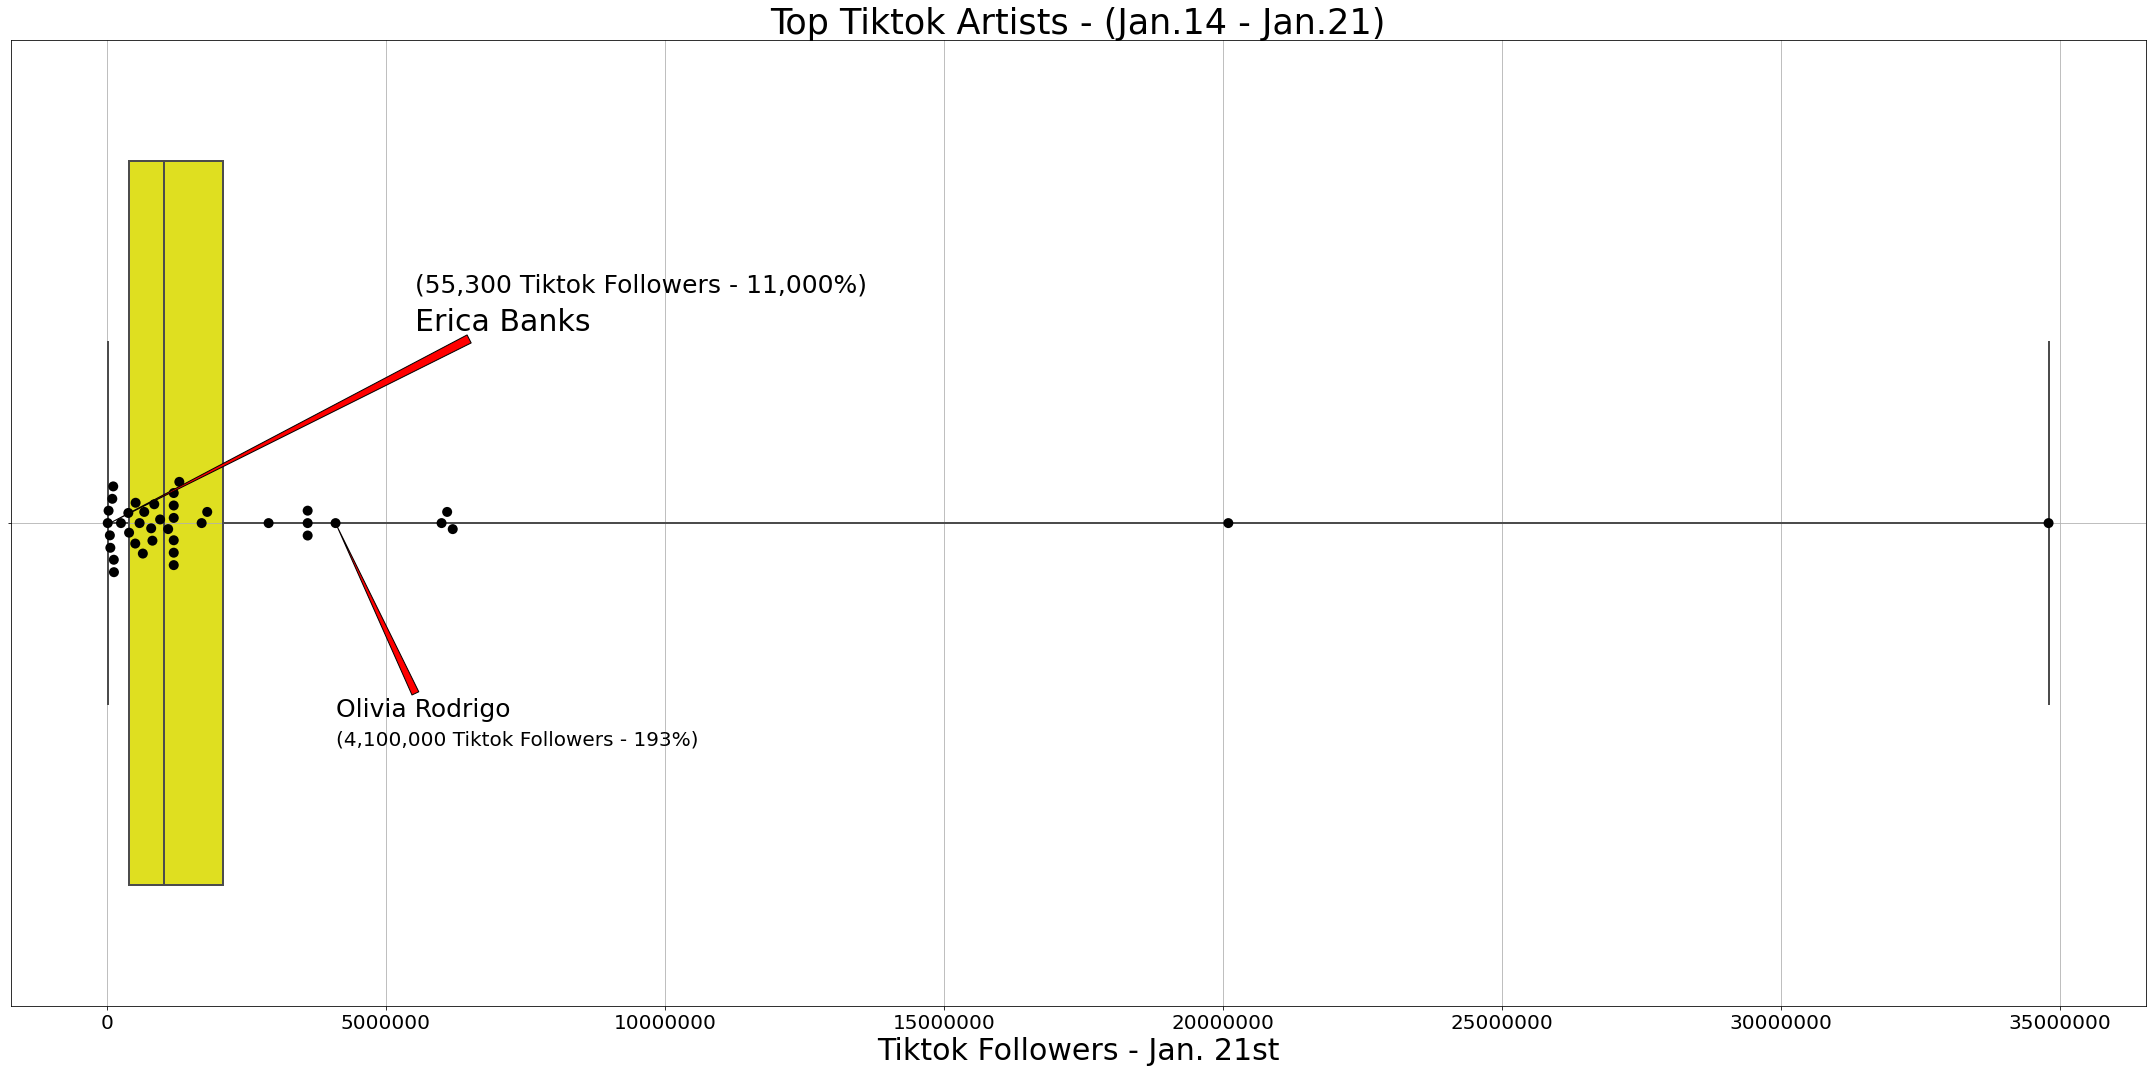

In [147]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['Tiktok_f21'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['Tiktok_f21'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=35)
plt.xlabel('Tiktok Followers - Jan. 21st', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate outlier data point
plt.annotate('Olivia Rodrigo',xy=(4100000.0,0),xytext=(4100000.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=25)
plt.annotate('(4,100,000 Tiktok Followers - 193%)',xy=(4100000.0,0),xytext=(4100000.0,.23),
                                                                                       fontsize=20)
#annotate second artist to double followers

plt.annotate('Erica Banks',xy=(55300.0,0),xytext=(5530000.0,-.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
                                                                                       fontsize=30)
plt.annotate('(55,300 Tiktok Followers - 11,000%)',xy=(55300.0,0),xytext=(5530000.0,-.24),
                                                                                       fontsize=25)



plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
plt.savefig('visuals/tk_f21.jpeg')
plt.tight_layout()
plt.show()

In [151]:
top_tktracks.sort_values('TK%', ascending=False)

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,...,IG_f31,TW_f31,Tiktok_f31,Tiktok_l31,Tiktok_l21,tiktok_engagement(31),tiktok_engagement(21),TW%,IG%,TK%
index,,,,,,,,,,,,,,,,,,,,,
1,2,2021-01-21,Buss It,Erica Banks,USUYG1312999,0.285714,29555553.0,33,2020-05-15,2020-12-31,...,126223.0,21915.0,493.0,741.0,182600.0,0.665317,0.302848,21.022131,91.261498,11117.038540
39,40,2021-01-21,drivers license,Olivia Rodrigo,USUG12004749,NaN,32507149.0,12,2021-01-08,2020-12-31,...,2361247.0,127746.0,1400000.0,13000000.0,28500000.0,0.107692,0.143860,270.644873,111.504176,192.857143
3,4,2021-01-21,Drugs (feat. Two Feet),UPSAHL,USQX91803133,19.142857,22290224.0,60,2019-01-18,2020-12-31,...,85951.0,5998.0,375100.0,6500000.0,9100000.0,0.057708,0.056088,26.858953,8.148829,36.070381
80,81,2021-01-21,oops!,Yung Gravy 🍯,USUM72019052,2.428571,31524146.0,46,2020-10-02,2020-12-31,...,1372760.0,236022.0,1400000.0,8900000.0,12700000.0,0.157303,0.141732,1.510876,1.439654,28.571429
95,96,2021-01-21,I Am (feat. Flo Milli),Yung Baby Tate,QZ5FA2050544,10.428571,32149829.0,24,2020-12-04,2020-12-31,...,107165.0,43987.0,101300.0,909700.0,1200000.0,0.111355,0.106917,6.511015,5.163066,26.653504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,93,2021-01-21,Mungkin Hari Ini Esok Atau Nanti,Anneth,FRX872024128,10.571429,31733715.0,54,2020-10-20,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,94,2021-01-21,Among Us,Sembari +,QZNWQ2008975,-0.428571,31876320.0,51,2020-11-01,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,95,2021-01-21,Casal Bem Louco,MC Marks,BRRGE1810075,14.000000,20499461.0,37,2018-08-31,2020-12-31,...,NaN,366.0,NaN,NaN,NaN,NaN,NaN,-0.273224,NaN,NaN


In [20]:
top_tktracks.loc[top_tktracks['artist'] == 'Olivia Rodrigo'][['slisteners_before', 'slisteners_after']]

,slisteners_before,slisteners_after
index,,
39,4701594.0,17935660.0


## Spotify Listeners

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


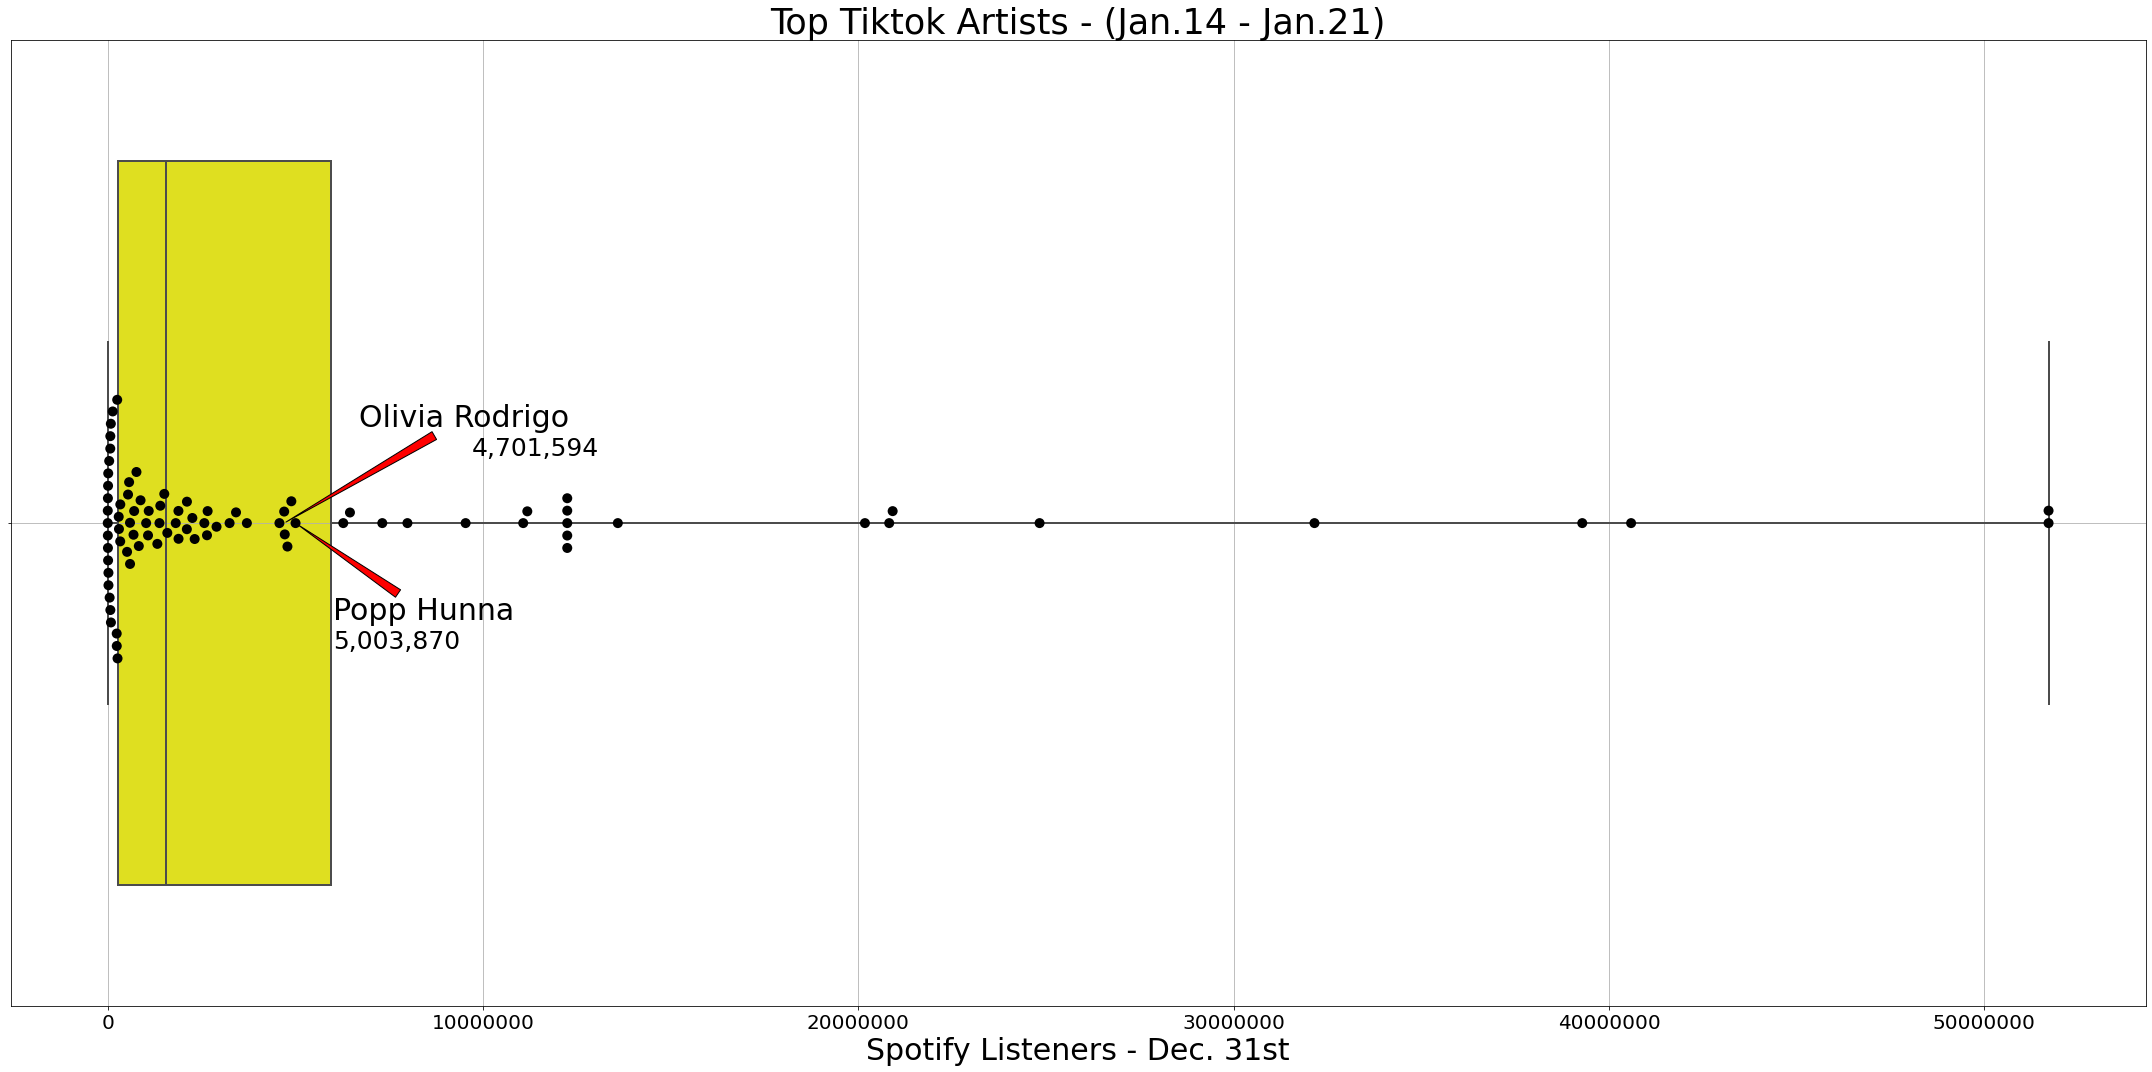

In [92]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['slisteners_before'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['slisteners_before'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=35)
plt.xlabel('Spotify Listeners - Dec. 31st', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate outlier data point
# plt.annotate('Olivia Rodrigo',xy=(4701594.0,0),xytext=(4701594.0,.2) ,arrowprops=dict(facecolor='red', arrowstyle='wedge'),
#                                                                                        fontsize=25)
# plt.annotate('(4,701,594 Spotify Listeners)',xy=(4701594.0,0),xytext=(4701594.0,.23),
#                                                                                        fontsize=15)
#annotate records who start below the third quartile on the 31st and end up above the third quartile after tiktok
num=0
ya=.1
yb=-.1
yc=.15
for track in top_tktracks.iterrows():
    if track[1]['slisteners_before'] <= top_tktracks['slisteners_before'].quantile(.75) and track[1]['slisteners_after'] > top_tktracks['slisteners_after'].quantile(.75):
        if (num % 2) == 0:
            plt.annotate(track[1]['artist'], xy=(track[1]['slisteners_before'], 0),xytext=(track[1]['slisteners_before']+1000000, ya),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            num+=1
            
            plt.annotate(insert_thousands_commas(track[1]['slisteners_before']), xy=(track[1]['slisteners_before'], 0),xytext=(track[1]['slisteners_before']+1000000, ya+.03),
                      fontsize=25)
            ya+=-.75
            
        else:
            plt.annotate(track[1]['artist'], xy=(track[1]['slisteners_before'], 0),xytext=(track[1]['slisteners_before']+2000000, yb),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            num+=1
            plt.annotate(insert_thousands_commas(track[1]['slisteners_before']), xy=(track[1]['slisteners_before'], 0),xytext=(track[1]['slisteners_before']+5000000, yb+.03),
                      fontsize=25)
            yb+=.75
            
plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
plt.savefig('visuals/sl_f31.jpeg')
plt.tight_layout()
plt.show()

/home/bull/Documents/practice1/test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


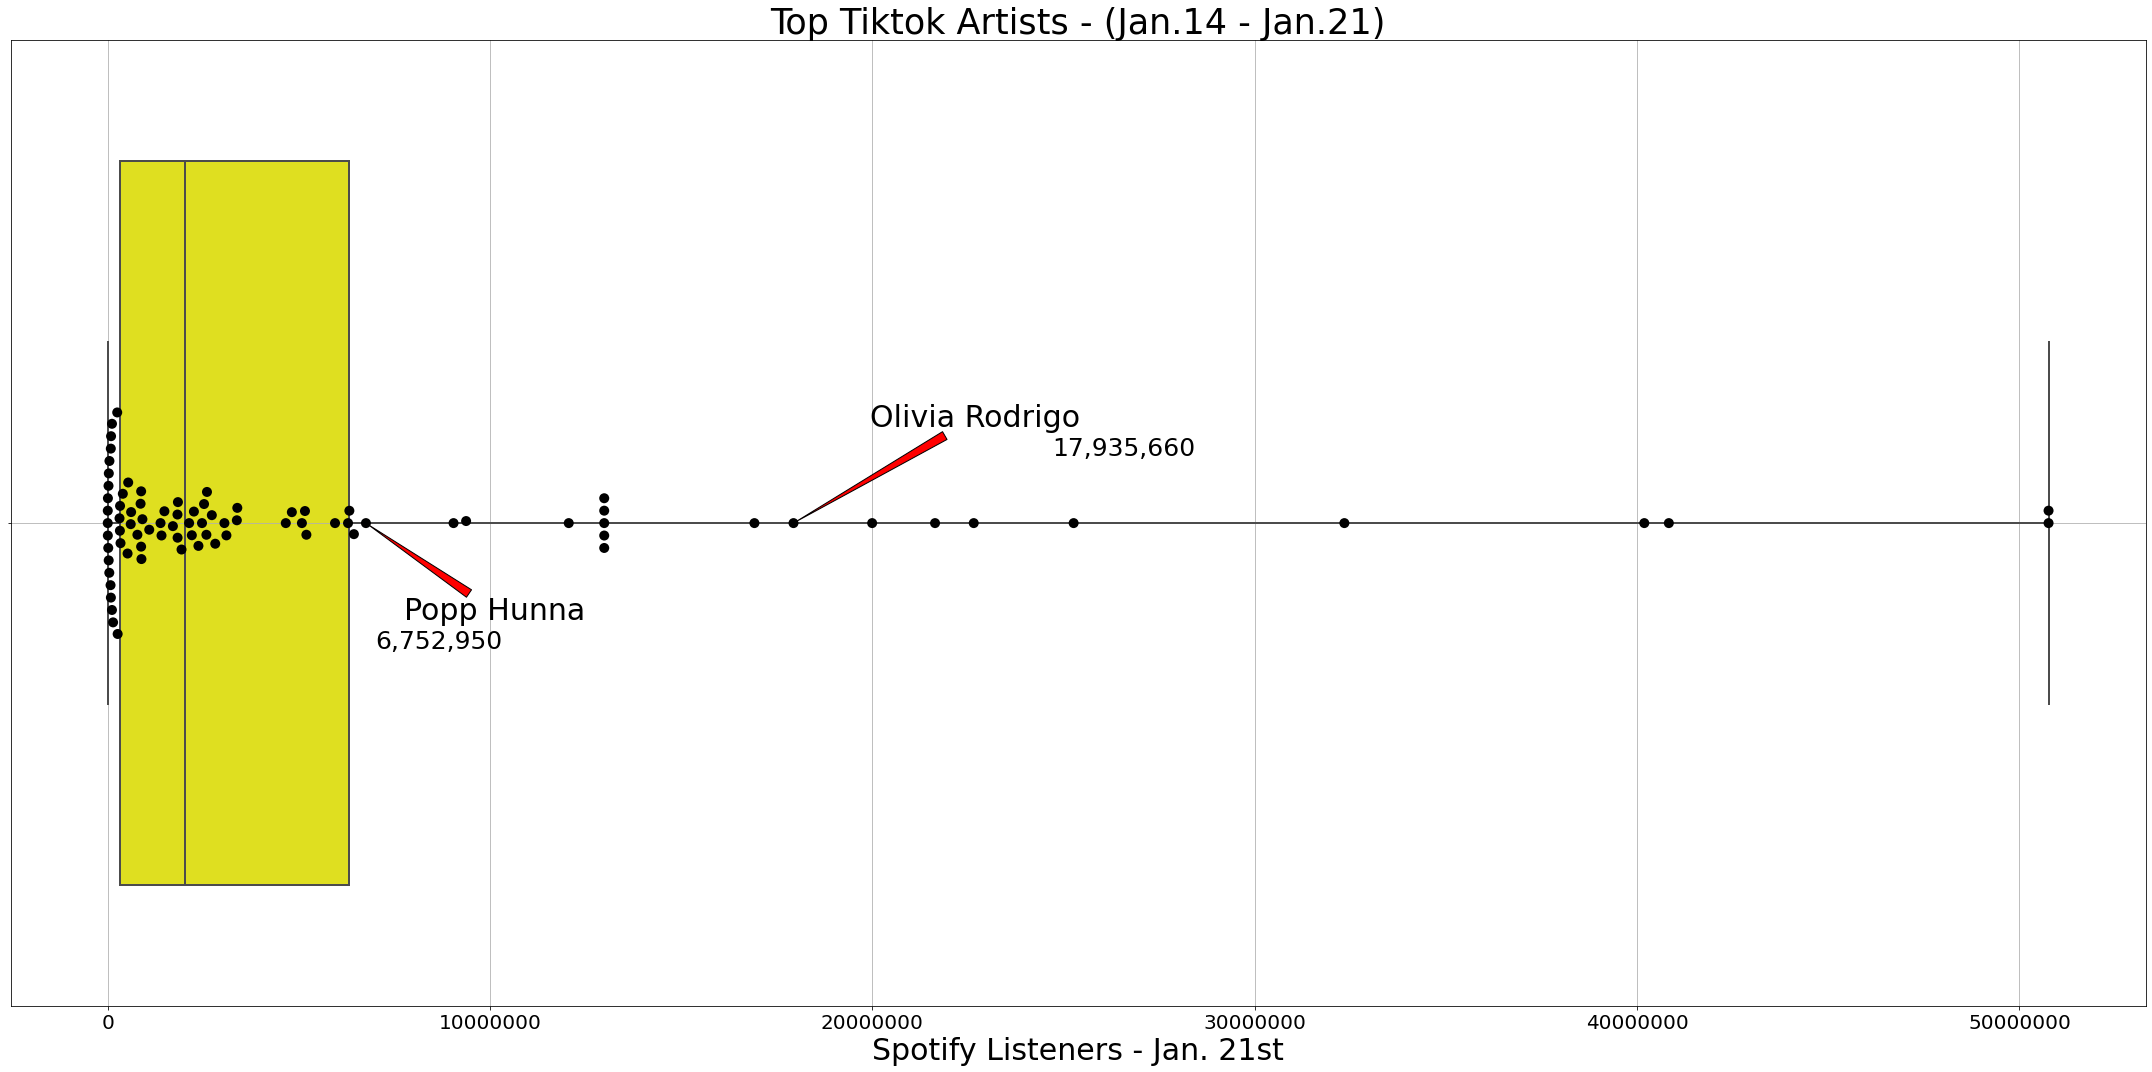

In [93]:
from matplotlib.pyplot import *

fig = figure(figsize=(30,15))  # define the figure window
ax1  = fig.add_subplot(111)   # define the axis
sns.boxplot(top_tktracks['slisteners_after'], fliersize=1,linewidth=2, whis=30,width=.75, color='yellow')
sns.swarmplot(data=top_tktracks,x=top_tktracks['slisteners_after'], color='black', size=10)
plt.title('Top Tiktok Artists - (Jan.14 - Jan.21)', fontsize=35)
plt.xlabel('Spotify Listeners - Jan. 21st', fontsize=30)
plt.ticklabel_format(style='plain', axis='x', ) #change xaxis from sci to plain style

#annotate records who start below the third quartile on the 31st and end up above the third quartile after tiktok
num=0
ya=.1
yb=-.1
yc=.15
for track in top_tktracks.iterrows():
    if track[1]['slisteners_before'] <= top_tktracks['slisteners_before'].quantile(.75) and track[1]['slisteners_after'] > top_tktracks['slisteners_after'].quantile(.75):
        if (num % 2) == 0:
            plt.annotate(track[1]['artist'], xy=(track[1]['slisteners_after'], 0),xytext=(track[1]['slisteners_after']+1000000, ya),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            num+=1
            
            plt.annotate(insert_thousands_commas(track[1]['slisteners_after']), xy=(track[1]['slisteners_after'], 0),xytext=(track[1]['slisteners_before']+2000000, ya+.03),
                      fontsize=25)
            ya+=-.75
            
        else:
            plt.annotate(track[1]['artist'], xy=(track[1]['slisteners_after'], 0),xytext=(track[1]['slisteners_after']+2000000, yb),
                     arrowprops=dict(facecolor='red', arrowstyle='wedge'), fontsize=30)
            num+=1
            plt.annotate(insert_thousands_commas(track[1]['slisteners_after']), xy=(track[1]['slisteners_after'], 0),xytext=(track[1]['slisteners_before']+20005000, yb+.03),
                      fontsize=25)
            yb+=.75
            

plt.tick_params(axis='x', which='major', labelsize=20)
plt.grid(axis='both')
plt.savefig('visuals/sl_f21.jpeg')
plt.tight_layout()
plt.show()

In [97]:
top_tktracks.loc[top_tktracks['artist'] == 'Olivia Rodrigo']

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,...,Tiktok_f14,Tiktok_f21,IG_f31,TW_f31,Tiktok_f31,Tiktok_l31,Tiktok_l21,tiktok_engagement(31),tiktok_engagement(21),TW%
index,,,,,,,,,,,,,,,,,,,,,
39,40,2021-01-21,drivers license,Olivia Rodrigo,USUG12004749,NaN,32507149.0,12,2021-01-08,2020-12-31,...,3200000.0,4100000.0,2361247.0,127746.0,1400000.0,13000000.0,28500000.0,0.107692,0.14386,270.644873


In [94]:
get_summary_statistics(top_tktracks['slisteners_before'].dropna())

Min: 27
Mean: 6,058,119
Max: 51,712,240
25th percentile: 268,772
Median: 1,546,853
75th percentile: 5,957,791
Interquartile range (IQR): 5,689,019


In [164]:
top_tktracks.head()

,rank,added_at,title,artist,isrc,velocity,cm_id,time_on_chart,release_dates,before_tiktok_date,...,TW_f31,Tiktok_f31,Tiktok_l31,Tiktok_l21,tiktok_engagement(31),tiktok_engagement(21),TW%,IG%,TK%,sl%
index,,,,,,,,,,,,,,,,,,,,,
0,1,2021-01-21,Shower,Becky G,USRC11400866,3.142857,15676244.0,69,2014-10-17,2020-12-31,...,3103665.0,6000000.0,29900000.0,30700000.0,0.200669,0.198697,0.559468,0.022635,1.666667,-0.905028
1,2,2021-01-21,Buss It,Erica Banks,USUYG1312999,0.285714,29555553.0,33,2020-05-15,2020-12-31,...,21915.0,493.0,741.0,182600.0,0.665317,0.302848,21.022131,91.261498,11117.038540,209.760775
2,3,2021-01-21,Aesthetic,Xilo,QZFZ22071847,0.000000,28796568.0,224,2020-02-14,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.040963
3,4,2021-01-21,Drugs (feat. Two Feet),UPSAHL,USQX91803133,19.142857,22290224.0,60,2019-01-18,2020-12-31,...,5998.0,375100.0,6500000.0,9100000.0,0.057708,0.056088,26.858953,8.148829,36.070381,31.656294
4,5,2021-01-21,Oh No,Kreepa,USUYG1287925,0.285714,29425832.0,88,2019-12-13,2020-12-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.119144
